In [3]:
from pathlib import Path
from collections import Counter, defaultdict
import random
import re

import pandas as pd
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup

In [4]:
parent_dir = Path.cwd()

In [5]:
names_dir = parent_dir / "names"

In [6]:
def parse_baby_names(data_dir: Path, start_year: int = 1880, end_year: int = 2023) -> pd.DataFrame:
    """
    Parses baby name files from yob<year>.txt into a single DataFrame.

    Parameters:
        data_dir (Path): Path to directory containing yob<year>.txt files
        start_year (int): Starting year of data
        end_year (int): Ending year of data

    Returns:
        pd.DataFrame: Combined DataFrame with columns ['Name', 'Gender', 'Count', 'Year']
    """
    all_data = []

    for year in range(start_year, end_year + 1):
        file_path = data_dir / f'yob{year}.txt'
        if not file_path.exists():
            print(f"Warning: {file_path} does not exist. Skipping.")
            continue
        
        df = pd.read_csv(file_path, header=None, names=["Name", "Gender", "Count"])
        df["Year"] = year
        all_data.append(df)

    return pd.concat(all_data, ignore_index=True)

In [7]:
baby_names_df = parse_baby_names(names_dir)

In [8]:
baby_names_df.head()

,Name,Gender,Count,Year
0,Mary,F,7065,1880
1,Anna,F,2604,1880
2,Emma,F,2003,1880
3,Elizabeth,F,1939,1880
4,Minnie,F,1746,1880


In [9]:
baby_names_df.count()

Name      2117219
Gender    2117219
Count     2117219
Year      2117219
dtype: int64

In [10]:
def get_top_10_names_by_year(df: pd.DataFrame) -> pd.DataFrame:
    # Group by Year and Gender, then take top 10 names by Count
    top_names = (
        df.groupby(['Year', 'Gender'], group_keys=False)
          .apply(lambda g: g.nlargest(10, 'Count'))
          .reset_index(drop=True)
    )
    return top_names

In [11]:
top_10_by_year_df = get_top_10_names_by_year(baby_names_df)

/tmp/ipykernel_8230/3531648151.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.nlargest(10, 'Count'))


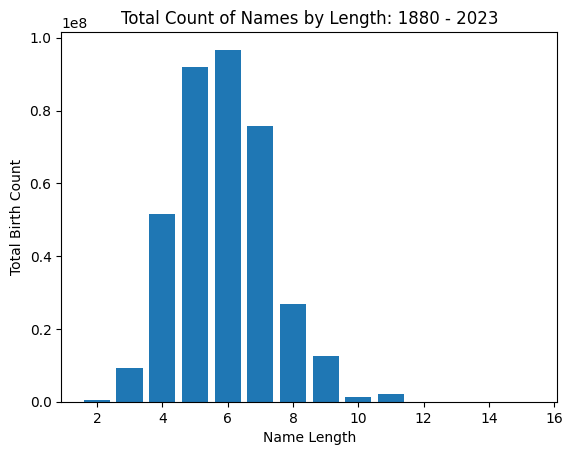

In [12]:
baby_names_df["NameLength"] = baby_names_df["Name"].str.len()
name_length_dist = baby_names_df.groupby("NameLength")["Count"].sum().reset_index()

plt.figure()
plt.bar(name_length_dist["NameLength"], name_length_dist["Count"])
plt.title("Total Count of Names by Length: 1880 - 2023")
plt.xlabel("Name Length")
plt.ylabel("Total Birth Count")
plt.show()

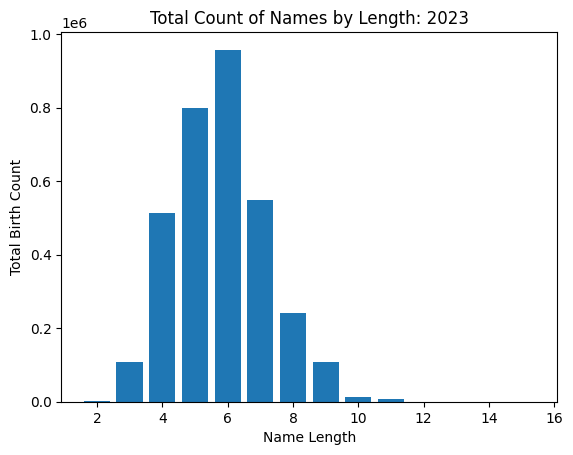

In [13]:
baby_names_df["NameLength"] = baby_names_df["Name"].str.len()

baby_names_only_2023 = baby_names_df[baby_names_df["Year"] == 2023]

name_length_dist = baby_names_only_2023.groupby("NameLength")["Count"].sum().reset_index()

plt.figure()
plt.bar(name_length_dist["NameLength"], name_length_dist["Count"])
plt.title("Total Count of Names by Length: 2023")
plt.xlabel("Name Length")
plt.ylabel("Total Birth Count")
plt.show()

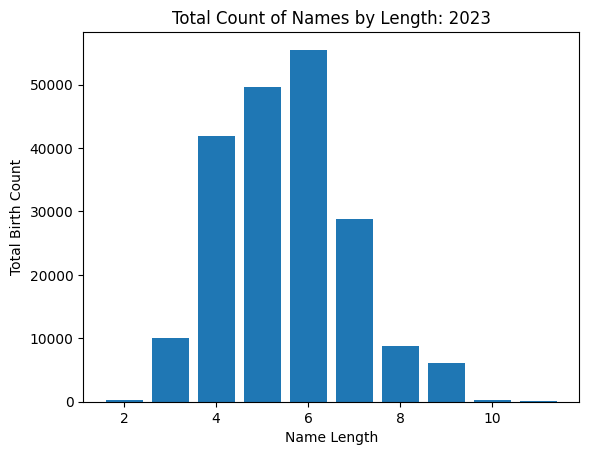

In [14]:
baby_names_df["NameLength"] = baby_names_df["Name"].str.len()

baby_names_only_1880 = baby_names_df[baby_names_df["Year"] == 1880]

name_length_dist = baby_names_only_1880.groupby("NameLength")["Count"].sum().reset_index()

plt.figure()
plt.bar(name_length_dist["NameLength"], name_length_dist["Count"])
plt.title("Total Count of Names by Length: 2023")
plt.xlabel("Name Length")
plt.ylabel("Total Birth Count")
plt.show()

In [15]:


def get_ngrams(name, n=2):
    return [name[i:i+n] for i in range(len(name) - n + 1)]

# Aggregate all names
all_names = baby_names_df["Name"].unique()

# Bigram and trigram counters
bigram_counter = Counter()
trigram_counter = Counter()

for name in all_names:
    name = name.lower()
    bigram_counter.update(get_ngrams(name, 2))
    trigram_counter.update(get_ngrams(name, 3))

print("Top 10 Bigrams:", bigram_counter.most_common(10))
print("Top 10 Trigrams:", trigram_counter.most_common(10))

Top 10 Bigrams: [('an', 17671), ('ar', 11675), ('el', 10443), ('ri', 10441), ('ha', 10213), ('na', 10190), ('ia', 9270), ('le', 8994), ('on', 8635), ('la', 8564)]
Top 10 Trigrams: [('sha', 4722), ('mar', 3006), ('ell', 2960), ('ari', 2878), ('ann', 2787), ('ana', 2500), ('lyn', 2237), ('ian', 2111), ('ani', 2013), ('nna', 2004)]


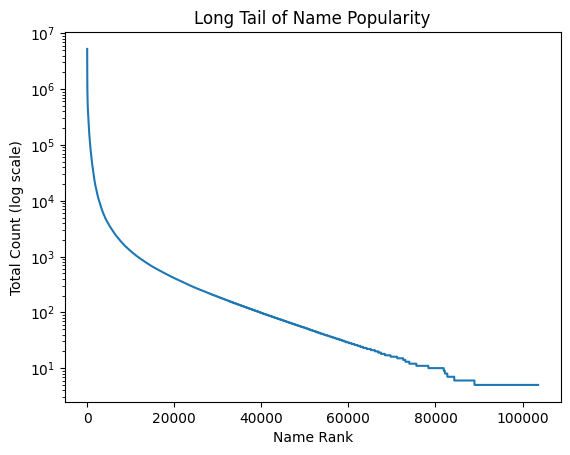

In [16]:
name_counts = baby_names_df.groupby("Name")["Count"].sum().sort_values(ascending=False).reset_index()

plt.figure()
plt.plot(name_counts["Count"].values)
plt.yscale("log")
plt.title("Long Tail of Name Popularity")
plt.xlabel("Name Rank")
plt.ylabel("Total Count (log scale)")
plt.show()

In [17]:
def build_weighted_markov_chain(df: pd.DataFrame, n: int = 3) -> dict:
    """
    Builds a weighted Markov chain of order n-1 using name frequencies.
    
    Args:
        df: DataFrame with columns 'Name' and 'Count'
        n: Order of the n-gram (e.g., 3 = trigram)
    
    Returns:
        dict mapping (n-1)-grams to distributions over next characters
    """
    transitions = defaultdict(Counter)

    for _, row in df.iterrows():
        name = row["Name"].lower()
        count = row["Count"]
        padded = "~" * (n - 1) + name + "$"

        for i in range(len(padded) - n + 1):
            prefix = padded[i:i+n-1]
            next_char = padded[i+n-1]
            transitions[prefix][next_char] += count  # weight by count

    # Normalize to probabilities
    model = {}
    for prefix, counter in transitions.items():
        total = sum(counter.values())
        model[prefix] = {char: freq / total for char, freq in counter.items()}

    return model


def generate_name(markov_model: dict, n: int = 3, max_len: int = 12) -> str:
    """
    Samples a name from the weighted Markov model.
    """
    prefix = "~" * (n - 1)
    name = ""

    while True:
        probs = markov_model.get(prefix)
        if not probs:
            break  # fallback if we hit a dead-end
        chars, weights = zip(*probs.items())
        next_char = random.choices(chars, weights=weights)[0]
        if next_char == "$" or len(name) >= max_len:
            break
        name += next_char
        prefix = prefix[1:] + next_char

    return name.capitalize()


In [18]:
female_names_after_2000 = baby_names_df[(baby_names_df["Year"] >= 2000) & (baby_names_df['Gender'] == 'F')]  # or df[df["Gender"] == "F"]

markov_model_f_after_2000 = build_weighted_markov_chain(female_names_after_2000, n=3)

In [19]:
markov_model_f_after_2000

{'~~': {'e': 0.07514780716777014,
  'h': 0.03217583835132524,
  'm': 0.09927591095339569,
  'a': 0.17140236953181795,
  's': 0.07743830590771669,
  'j': 0.06287228584391544,
  't': 0.022695143387911308,
  'l': 0.06176097005035031,
  'k': 0.07539866357538577,
  'b': 0.03445578364300323,
  'o': 0.012651228793575966,
  'g': 0.02661150919492737,
  'v': 0.017629794457460886,
  'r': 0.03598412554080533,
  'd': 0.02784034988450099,
  'n': 0.03107403950664514,
  'c': 0.057965804000793396,
  'i': 0.023444980021474382,
  'f': 0.008734438964084825,
  'p': 0.018836797989568103,
  'z': 0.013149243190552402,
  'y': 0.0059180581278277,
  'w': 0.004023737720426906,
  'q': 0.0014675653430412494,
  'u': 0.0003374276629435923,
  'x': 0.0017078211887799884},
 '~e': {'m': 0.37371711198632757,
  'l': 0.37147922865594085,
  'r': 0.03616380591260124,
  'v': 0.1291370591473285,
  's': 0.04456832895098161,
  'd': 0.019313381407543663,
  'b': 0.001914065781669858,
  'i': 0.006411462075416575,
  'u': 0.0021416471

In [20]:
for _ in range(10):
    print(generate_name(markov_model_f_after_2000, n=3))

Kaya
Isony
Aber
Sabexisashi
Sa
Afia
Merlorie
Camilla
Jayl
Maliviana


In [21]:
male_names_after_2000 = baby_names_df[(baby_names_df["Year"] >= 2000) & (baby_names_df['Gender'] == 'M')]  # or df[df["Gender"] == "F"]

markov_model_m_after_2000 = build_weighted_markov_chain(male_names_after_2000, n=3)

In [22]:
for _ in range(10):
    print(generate_name(markov_model_m_after_2000, n=3))

Jas
Kado
Ryark
Ne
Jereen
Thyruel
Ar
Deashuan
Calogael
Trandren


In [23]:
def build_variable_order_chain(df, max_n=3):
    """
    Builds a variable-order Markov chain up to order max_n, weighted by name frequency.
    Returns a dictionary of order -> {prefix: Counter(next_char)}
    """
    orders = {k: defaultdict(Counter) for k in range(1, max_n + 1)}

    for _, row in df.iterrows():
        name = row["Name"].lower()
        count = row["Count"]
        padded = "~" * (max_n - 1) + name + "$"

        for n in range(1, max_n + 1):
            for i in range(len(padded) - n + 1):
                prefix = padded[i:i+n-1]
                next_char = padded[i+n-1]
                orders[n][prefix][next_char] += count

    # Convert to probability distributions
    prob_models = {}
    for n, order_dict in orders.items():
        prob_models[n] = {
            prefix: {
                char: freq / sum(counter.values())
                for char, freq in counter.items()
            }
            for prefix, counter in order_dict.items()
        }

    return prob_models


def generate_name_var_order(model_dict, max_n=3, max_len=12, backoff_weights=None):
    """
    Generate a name using a variable-order Markov chain with optional weighted interpolation.
    """
    if backoff_weights is None:
        # Stupid backoff: use highest available order, fall back if needed
        backoff_weights = [0.0] * max_n
        backoff_weights[-1] = 1.0  # pure highest-order

    prefix = "~" * (max_n - 1)
    name = ""

    while True:
        dist = Counter()

        # Interpolate or back off
        for order in reversed(range(1, max_n + 1)):
            pfx = prefix[-(order - 1):] if order > 1 else ""
            probs = model_dict.get(order, {}).get(pfx)
            if probs:
                weight = backoff_weights[order - 1] if backoff_weights else 1.0
                for char, prob in probs.items():
                    dist[char] += weight * prob
                break  # "stupid" backoff: use first available and break

        if not dist:
            break  # no valid next char

        chars, weights = zip(*dist.items())
        next_char = random.choices(chars, weights=weights)[0]

        if next_char == "$" or len(name) >= max_len:
            break

        name += next_char
        prefix = prefix[1:] + next_char

    return name.capitalize()

In [24]:
variable_order_model_f_after_2000 = build_variable_order_chain(female_names_after_2000)

In [25]:
variable_order_model_m_after_2000 = build_variable_order_chain(male_names_after_2000)

In [26]:
for _ in range(10):
    print(generate_name_var_order(variable_order_model_f_after_2000))

Brina
Paila
Grah
Rey
Rynna
Ezleagh
Emmara
Amirel
Kaya
Avana


In [27]:
def build_reverse_chain(df, n=3):
    """
    Builds a frequency-weighted Markov chain in reverse order.
    """
    transitions = defaultdict(Counter)

    for _, row in df.iterrows():
        name = row["Name"].lower()
        count = row["Count"]
        padded = "$" + name[::-1] + "~" * (n - 1)  # reverse + padding

        for i in range(len(padded) - n + 1):
            prefix = padded[i:i + n - 1]
            next_char = padded[i + n - 1]
            transitions[prefix][next_char] += count

    # Normalize to probabilities
    model = {}
    for prefix, counter in transitions.items():
        total = sum(counter.values())
        model[prefix] = {char: freq / total for char, freq in counter.items()}

    return model


def generate_name_with_suffix(reverse_model, suffix, n=3, max_len=12):
    """
    Generates a name that ends with the given suffix, using a reverse Markov chain.
    """
    suffix = suffix.lower()
    name_rev = suffix[::-1]
    prefix = name_rev[:n - 1] if len(name_rev) >= n - 1 else name_rev + "~" * (n - 1 - len(name_rev))

    while len(name_rev) < max_len:
        probs = reverse_model.get(prefix)
        if not probs:
            break
        chars, weights = zip(*probs.items())
        next_char = random.choices(chars, weights=weights)[0]
        if next_char == "~":
            break
        name_rev += next_char
        prefix = name_rev[-(n - 1):]

    name = name_rev[::-1]
    return name.capitalize()


In [28]:
# Use your baby_names_df as usual
reverse_model = build_reverse_chain(female_names_after_2000, n=3)

# Generate names ending in "bella"
for _ in range(5):
    print(generate_name_with_suffix(reverse_model, suffix="a", n=3))

A
A
A
A
A


In [29]:
from collections import defaultdict, Counter
import random

def build_reverse_variable_order_chain(df, max_n=3):
    """
    Builds a reverse-order Markov model of multiple orders (1 to max_n), frequency-weighted.
    """
    orders = {k: defaultdict(Counter) for k in range(1, max_n + 1)}

    for _, row in df.iterrows():
        name = row["Name"].lower()
        count = row["Count"]
        reversed_name = name[::-1]
        padded = "$" + reversed_name + "~" * (max_n - 1)

        for n in range(1, max_n + 1):
            for i in range(len(padded) - n + 1):
                prefix = padded[i:i+n-1] if n > 1 else ""
                next_char = padded[i+n-1]
                orders[n][prefix][next_char] += count

    # Normalize into probability models
    model = {}
    for n, order_dict in orders.items():
        model[n] = {
            prefix: {
                char: freq / sum(counter.values())
                for char, freq in counter.items()
            }
            for prefix, counter in order_dict.items()
        }

    return model

In [30]:
def generate_name_with_suffix_var_order(reverse_model_dict, suffix, max_n=3, max_len=12, backoff_weights=None):
    """
    Generates a name ending in a given suffix using a variable-order reverse Markov model.
    """
    if backoff_weights is None:
        backoff_weights = [0.1, 0.3, 0.6]  # e.g., unigram=10%, bigram=30%, trigram=60%

    suffix = suffix.lower()
    reversed_suffix = suffix[::-1]
    name_rev = reversed_suffix
    prefix = reversed_suffix[:max_n - 1] if len(reversed_suffix) >= max_n - 1 else reversed_suffix + "~" * (max_n - 1 - len(reversed_suffix))

    while len(name_rev) < max_len:
        dist = Counter()

        for order in reversed(range(1, max_n + 1)):
            pfx = name_rev[-(order - 1):] if order > 1 else ""
            probs = reverse_model_dict.get(order, {}).get(pfx)
            if probs:
                weight = backoff_weights[order - 1]
                for char, prob in probs.items():
                    dist[char] += weight * prob
                break  # stupid backoff: use first available

        if not dist:
            break  # no more data

        chars, weights = zip(*dist.items())
        next_char = random.choices(chars, weights=weights)[0]
        if next_char == "~":
            break

        name_rev += next_char

    return name_rev[::-1].capitalize()

In [31]:
# Use your baby_names_df subset
reverse_model = build_reverse_variable_order_chain(
    female_names_after_2000, max_n=3
)

In [32]:
# Generate names ending in 'son' or 'bella'
for _ in range(5):
    print(generate_name_with_suffix_var_order(reverse_model, "el", max_n=3))

Adel
Camellangel
Aydnel
Annadel
Bel


In [33]:
def clean_reference_footnotes(name: str) -> str:
    return re.sub(r"\[\d+\]$", "", name).strip()

def scrape_planet_names():
    url = "https://starwars.fandom.com/wiki/List_of_planets"
    headers = {
        "User-Agent": "Mozilla/5.0"
    }

    response = requests.get(url, headers=headers)
    response.raise_for_status()

    soup = BeautifulSoup(response.text, "html.parser")

    planet_names = set()

    # Find all tables on the page
    tables = soup.find_all("table", class_="wikitable")

    for table in tables:
        # Find the header row
        headers = [th.get_text(strip=True).lower() for th in table.find_all("th")]
        if "name" in headers:
            name_index = headers.index("name")
            # Iterate over the rows in the table
            for row in table.find_all("tr")[1:]:
                cells = row.find_all("td")
                if len(cells) > name_index:
                    name_cell = cells[name_index]
                    name = name_cell.get_text(strip=True)
                    name = clean_reference_footnotes(name)
                    if name:
                        planet_names.add(name)

    return sorted(planet_names)

# Example usage
planets = scrape_planet_names()
for planet in planets:
    print(planet)



5251977
73
Aaloth
Aargonar
Ab Dalis
Abafar
Abednedo
Abelor
Abregado-rae
Abrion Major
Absanz
Abtin
Actlyon
Adelphi
Aeos Prime
Aeten II
Affa
Affadar
Agamar
Agaris
Agoliba-Ado
Agoliba-Ena
Ah Re Won
Ahch-To
Ajara
Akiva
Alamass
Alaris
Albrae-Don
Alderaan
Aldhani
Aleen
Aleen Minor
Allst Prime
Allyuen
Aloxl
Aloxor
Alpinn
Alsakan
Aludia
Alun
Alzoc III
Ambria
Amethia Prime
Ammon IV
Ammuud
Anantapar
Anaxes
Andelm IV
Ando
Ando Prime
Andraven
Anelsana
Angcord
Angoth
Ankhural
Anoat
Ansion
Antar
Anthan Prime
Antillion
Anzat
Aq Vetina
Aquaris
Arbiflux
Arbooine
Arbra
Arcana
Ardennia
Argai Minor
Arges
Aria Prime
Aricho
Aridus
Arieli
Aris
Arkania
Arkanis
Arli
Arreyel
Artemesium
Artiod Minor
Arvala-7
Ashas Ree
Askaji
Asmeru
Asternin
Asusto
At Achrann
At Acoda
At Aravin
At Arissia
At Attin
At Aytuu
Atalia
Athulla
Atoa
Atollon
Atraken
Atterra Alpha
Atterra Bravo
Atterra Primo
Aubadas
Auratera
Avedot
Avidich
Axxila
Aynaboni
B'ankora homeworld
Bakura
Balagash
Ballum
Balmorra
Balnab
Balosar
Bamayar
Bamayar IX

In [34]:
# Assuming you already have your list of planet names
planets = sorted(planets)  # Or whatever list you're using

# Save to file
with open("planets.txt", "w", encoding="utf-8") as f:
    for planet in planets:
        f.write(planet + "\n")

In [35]:
planets_file = parent_dir / "planets" / "planets.txt"

In [36]:
with open(planets_file, 'r') as f:
    planets = f.read().splitlines()

In [37]:
planets

['Aaloth',
 'Aargonar',
 'Ab Dalis',
 'Abafar',
 'Abednedo',
 'Abelor',
 'Abregado-rae',
 'Abrion Major',
 'Absanz',
 'Abtin',
 'Actlyon',
 'Adelphi',
 'Aeos Prime',
 'Aeten II',
 'Affa',
 'Affadar',
 'Agamar',
 'Agaris',
 'Agoliba-Ado',
 'Agoliba-Ena',
 'Ah Re Won',
 'Ahch-To',
 'Ajara',
 'Akiva',
 'Alamass',
 'Alaris',
 'Albrae-Don',
 'Alderaan',
 'Aldhani',
 'Aleen',
 'Aleen Minor',
 'Allst Prime',
 'Allyuen',
 'Aloxl',
 'Aloxor',
 'Alpinn',
 'Alsakan',
 'Aludia',
 'Alun',
 'Alzoc III',
 'Ambria',
 'Amethia Prime',
 'Ammon IV',
 'Ammuud',
 'Anantapar',
 'Anaxes',
 'Andelm IV',
 'Ando',
 'Ando Prime',
 'Andraven',
 'Anelsana',
 'Angcord',
 'Angoth',
 'Ankhural',
 'Anoat',
 'Ansion',
 'Antar',
 'Anthan Prime',
 'Antillion',
 'Anzat',
 'Aq Vetina',
 'Aquaris',
 'Arbiflux',
 'Arbooine',
 'Arbra',
 'Arcana',
 'Ardennia',
 'Argai Minor',
 'Arges',
 'Aria Prime',
 'Aricho',
 'Aridus',
 'Arieli',
 'Aris',
 'Arkania',
 'Arkanis',
 'Arli',
 'Arreyel',
 'Artemesium',
 'Artiod Minor',
 'Arvala-

In [38]:
def extract_planet_root(name):
    return name.split()[0].lower()

def random_segment(word, min_len=2, max_len=5):
    if len(word) <= min_len:
        return word
    start = random.randint(0, len(word) - min_len)
    end = min(len(word), start + random.randint(min_len, max_len))
    return word[start:end]

def generate_surname(planets, suffixes=None):
    if suffixes is None:
        human_suffixes = ["son", "er", "ar", "an", "en", "ell", "in", "ix", "or", "ius", "man", "ley", "win", "eth", "dan", "vek"]
        twilek_suffixes = ["eth", "ira", "urra", "ven", "asha", "il", "ren", "ae", "nek", "eesh", "ali", "ohl", "ami"]
        trandoshan_suffixes = ["ssk", "arsh", "okk", "rak", "nak", "zor", "gash", "azz", "och", "thok", "kren", "usk", "drass"]
        suffixes = human_suffixes + twilek_suffixes + trandoshan_suffixes

    root_word = extract_planet_root(random.choice(planets))
    segment = random_segment(root_word)
    suffix = random.choice(suffixes)
    
    return (segment + suffix).capitalize()

In [39]:
for _ in range(10):
    print(generate_surname(planets))

Eftaley
Taokk
Sraira
Wadier
Enira
Monthok
Uvenix
Nausk
Sheth
Allerak


In [40]:
for _ in range(10):
    print(generate_name_var_order(variable_order_model_f_after_2000), generate_surname(planets))

Sony Hihvek
Nanna V'rell
Ann Ah'kren
Jaden Rrson
Ma Anssk
Kyyah Orivdan
Jailey Ndonor
Assa Disson
Olil Ermaeth
Mil Tarak


In [41]:
for _ in range(10):
    print(generate_name_var_order(variable_order_model_m_after_2000), generate_surname(planets))

Herey Rdgash
Dantert Ermoer
Ger Rrixvek
Tavihsiroy Endekrak
Saviel Aleesh
Jamel Thusgash
Marreydent Ethiadan
Dinichamesse Araren
Saarcholn Anter
Cary Idiwin
